In [2]:
import requests
from __future__ import division, print_function
humpacks_url = "http://www.flukebook.org/listImages.jsp?genus=Megaptera&species=novaeangliae"
r = requests.get(humpacks_url)
print(r.status_code)

200


In [3]:
img_points_info = r.json()

In [4]:
img_points_info['mediaAssets'][0]

{u'catalogNumber': u'00403d3e-a5a0-4bf7-83e6-bf247749069f',
 u'individualID': u'474001',
 u'referenceImageURL': u'http://www.flukebook.org/caribwhale_data_dir/encounters/0/0/00403d3e-a5a0-4bf7-83e6-bf247749069f/extract00403d3e-a5a0-4bf7-83e6-bf247749069f.jpg',
 u'referencePoints': [{u'x': u'92.12674743709226',
   u'y': u'37.205032618825726'},
  {u'x': u'935.4408201304753', u'y': u'377.36533084808946'},
  {u'x': u'1847.8499534016776', u'y': u'145.27679403541472'}]}

In [5]:
from train_utils import dataset_loc
from os.path import exists, join
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
imgs_dir = join(dataset_loc, "Flukes/Flukebook/images")
def downloadImage(img_url, cache=True):
    fn = img_url.split('/')[-1]
    stored_fn = join(imgs_dir, fn)
    if (not cache) or not exists(stored_fn):
        r = requests.get(img_url, stream=True)
        with open(stored_fn, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
    return stored_fn

def displayPoints(imginfo, cache=True):
    # first download the image if it's not there
    imgfn = downloadImage(imginfo['referenceImageURL'], cache=cache)
    img = cv2.imread(imgfn)
    for pt in imginfo['referencePoints']:
        cv2.circle(img, (int(float(pt['x'])), int(float(pt['y']))), 10, (0,255,0), -1)
    plt.figure(figsize=(15,15))
    plt.imshow(img)

Couldn't import dot_parser, loading of dot files will not be possible.
Conv2DLayer = <class 'lasagne.layers.conv.Conv2DLayer'>
MaxPool2DLayer = <class 'lasagne.layers.pool.MaxPool2DLayer'>

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


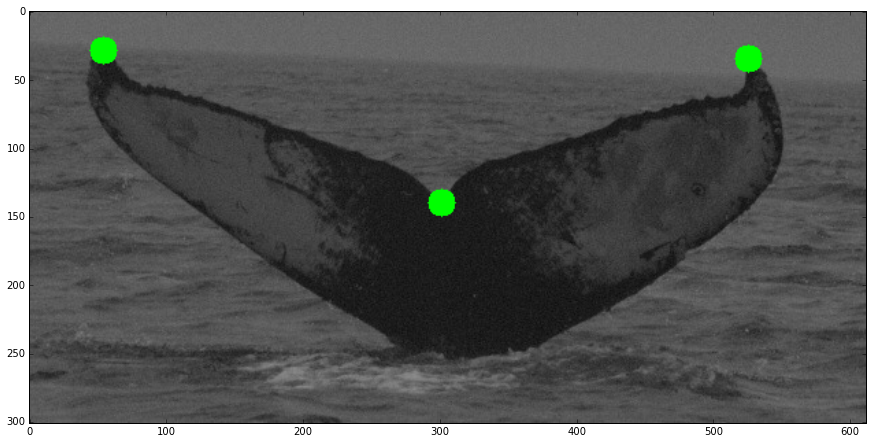

In [26]:
displayPoints(img_points_info['mediaAssets'][18])

In [6]:
for imginfo in img_points_info['mediaAssets']:
    if len(imginfo['referencePoints']) != 3:
        print(imginfo)

In [7]:
fb_curvatures = []
import utool as ut
for imginfo in ut.ProgressIter(img_points_info['mediaAssets'], lbl='Image'):
    img_url = imginfo['referenceImageURL']
    imgfn = downloadImage(img_url, cache=True)
    curvinfo = {'fn':imgfn.split('/')[-1],
                'id':imginfo['individualID'],}
    read_pts = lambda pts: {'x':int(float(pts['x'])), 'y':int(float(pts['y']))}
    img_points = sorted(map(read_pts, imginfo['referencePoints']), key=lambda x: x['x'])
    curvinfo['points'] = {'left':img_points[0], 'notch':img_points[1], 'right':img_points[2]}
    fb_curvatures.append(curvinfo)

Image    1/1294...  rate=18558.52 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:58 EST
Image    2/1294...  rate=3758.32 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:58 EST
Image    3/1294...  rate=4253.84 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:58 EST
Image    4/1294...  rate=4293.03 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:58 EST
Image    5/1294...  rate=4788.00 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:58 EST
Image    6/1294...  rate=4899.86 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:58 EST
Image    7/1294...  rate=4899.86 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:58 EST
Image    8/1294...  rate=4928.65 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:58 EST
Image    9/1294...  rate=4364.50 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:58 EST
Image   10/1294...  rate=4877.07 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:58 EST
Image   11/1294...  rate=4928.65 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:58 EST
Image   12/1294...  rate=4563.97 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:58 EST
Ima

In [20]:
from scipy.stats import norm
import numpy as np
def find_seam(img, start, end, center=None, n_neighbors=3, scale=1):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    assert(n_neighbors % 2 == 1)
    #n_neighbors = img.shape[0]
    neighbor_range = range(-1*(n_neighbors // 2),1+(n_neighbors // 2))
    #weight_df = [norm.pdf(x, scale=scale) for x in neighbor_range]
    # start and end are x,y 
    # take the vertical gradients of the image
    gradient_y_image = 1*cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    # TODO maybe: blur before taking gradients to denoise
    # set the start point's vertical gradient to a very high value
    # for each row from start to end, the cost of each cell is the max
    # of the three neighbors to its left + its own cost
    # the max that is chosen is then stored for each pixel in a column so we can backtrack
    gradient_y_image[:,start[0]] = np.inf # make sure this is where the path starts
    gradient_y_image[start[1],start[0]] = 0 #np.max(gradient_y_image) + 1 # yeah I think this makes sense
    
    gradient_y_image[:,end[0]] = np.inf
    gradient_y_image[end[1],end[0]] = 0 #np.max(gradient_y_image) + 1
    if center is not None:
        # force it to go through the center
        gradient_y_image[:,center[0]] = np.inf
        gradient_y_image[center[1],center[0]] = 0
    # the goal of the above is to make the path end at 'end', but that probably can't be guaranteed regardless
    cost = np.zeros(gradient_y_image.shape)
    back = np.zeros(gradient_y_image.shape,dtype=np.int32)
    get_cost = lambda row, col, i : np.inf if ((row+i < 0) or (row+i >= gradient_y_image.shape[0])) else cost[row+i,col-1] + gradient_y_image[row,col]
    for col in range(start[0],end[0]+1):
        # this is the slow part
        for row in range(gradient_y_image.shape[0]):
            #candidates = [((cost[cell+i, col-1]+gradient_y_image[cell,col]) if
            #              ((cell+i > 0) and (cell+i < gradient_y_image.shape[0])) else -np.inf) 
            #              for i in (-1,0,1)]
            candidates = [get_cost(row, col, i) for i in neighbor_range]
            best = np.argmin(candidates)
            #print(candidates)
            back[row, col] = best - (n_neighbors // 2)
            cost[row, col] = candidates[best]
    # backtrack the seam
    path = [] # we know that the path is from end to start so we don't need to store the x values
    curr_y = end[1]
    path_cost = 0
    # we know that the optimal path must end at the end point since otherwise its cost is -inf
    for col in range(start[0],end[0]+1)[::-1]:
        path_cost += cost[curr_y,col]
        path.append((col,curr_y)) 
        next_ = curr_y + back[curr_y,col]
        curr_y = next_
    #plt.imshow(cost)
    return path, path_cost, cost

In [73]:
from collections import defaultdict
id_img_map = defaultdict(lambda: [])
for imginfo in img_points_info['mediaAssets']:
    id_img_map[imginfo['individualID']].append(imginfo['referenceImageURL'])
    
def make_dict_hist(dic):
    hist = defaultdict(lambda: 0)
    for id_ in dic:
        hist[len(dic[id_])] += 1
    return hist

id_img_hist = make_dict_hist(id_img_map)

In [77]:
len(id_img_map)

759

In [79]:
troubled_imgs = []

for imginfo, uriinfo in ut.ProgressIter(filter(lambda x: 'edge' not in x[0],
                                      zip(fb_curvatures, img_points_info['mediaAssets'])), lbl='Image'):
    imgfn = downloadImage(uriinfo['referenceImageURL'], cache=False)
    img = cv2.imread(join(imgs_dir, imgfn))
    xyconvert = lambda pt: (pt['x'], pt['y'])
    try:
        path, _, _ = find_seam(img, xyconvert(imginfo['points']['left']), 
                                xyconvert(imginfo['points']['right']), 
                           center=xyconvert(imginfo['points']['notch']),
                           n_neighbors=5)
    except IndexError:
        print("Extraction failed on image %s" % imginfo['fn'])
        
        if img.shape == (800,600):
            trouble_type = 1
        else:
            trouble_type = 2
        troubled_imgs.append((uriinfo['referenceImageURL'], trouble_type))
        continue
    print(img.shape)
    imginfo['edge'] = path


Image    0/66...  Extraction failed on image extract02b609d9-d156-44e2-976f-10e92fe03f44.jpg
Image    1/66...  rate=11.93 Hz, etr=0:00:05, ellapsed=0:00:00, wall=11:56 EST
Extraction failed on image extract040d01bb-c2ef-4e7a-97ce-b37cfff85fbb.jpg
Image    2/66...  rate=13.29 Hz, etr=0:00:04, ellapsed=0:00:00, wall=11:56 EST
Extraction failed on image extract08639860-6641-42c8-90db-38b72389720d.jpg
Image    3/66...  rate=12.70 Hz, etr=0:00:04, ellapsed=0:00:00, wall=11:56 EST
Extraction failed on image extract0cc32c9b-2376-4202-a759-3db7a3fcf571.jpg
Image    4/66...  rate=12.93 Hz, etr=0:00:04, ellapsed=0:00:00, wall=11:56 EST
Extraction failed on image extract0da9aac4-69eb-493d-97c3-3921dc6ec9b2.jpg
Image    5/66...  rate=13.03 Hz, etr=0:00:04, ellapsed=0:00:00, wall=11:56 EST
Extraction failed on image extract127b1ef7-eeeb-4478-97e6-fc77369a0aed.jpg
Image    6/66...  rate=12.91 Hz, etr=0:00:04, ellapsed=0:00:00, wall=11:56 EST
Extraction failed on image extract1acbcbd6-4e31-4e58-923c-

In [82]:
import json
with open(join(dataset_loc, 'flukebook_bad.json'), 'w') as f:
    json.dump(troubled_imgs, f)

In [32]:
print(fb_curvatures[-1]['edge'])

[(863, 6), (862, 6), (861, 7), (860, 7), (859, 7), (858, 7), (857, 7), (856, 8), (855, 8), (854, 8), (853, 8), (852, 8), (851, 8), (850, 8), (849, 8), (848, 8), (847, 8), (846, 9), (845, 9), (844, 9), (843, 9), (842, 10), (841, 10), (840, 10), (839, 11), (838, 11), (837, 11), (836, 12), (835, 12), (834, 12), (833, 12), (832, 13), (831, 13), (830, 13), (829, 14), (828, 14), (827, 14), (826, 15), (825, 15), (824, 15), (823, 16), (822, 16), (821, 17), (820, 17), (819, 17), (818, 17), (817, 17), (816, 17), (815, 18), (814, 18), (813, 18), (812, 18), (811, 19), (810, 19), (809, 19), (808, 19), (807, 19), (806, 20), (805, 20), (804, 20), (803, 20), (802, 21), (801, 21), (800, 21), (799, 22), (798, 22), (797, 22), (796, 23), (795, 23), (794, 23), (793, 23), (792, 23), (791, 23), (790, 24), (789, 24), (788, 24), (787, 24), (786, 24), (785, 24), (784, 24), (783, 25), (782, 25), (781, 25), (780, 26), (779, 26), (778, 26), (777, 26), (776, 26), (775, 26), (774, 27), (773, 28), (772, 28), (771, 28

In [40]:
for imginfo in filter(lambda x: 'edge' not in x, fb_curvatures):
    #imgfn = downloadImage(imginfo['fn'], cache=True)
    badimg = cv2.imread(join(imgs_dir, imginfo['fn']))
    if badimg.shape != (600, 800, 3):
        print(badimg.shape)
        print(imginfo['points'])

(1145, 3003, 3)
{'notch': {'y': 587, 'x': 1466}, 'right': {'y': 173, 'x': 3003}, 'left': {'y': 151, 'x': 148}}
(879, 1881, 3)
{'notch': {'y': 517, 'x': 1264}, 'right': {'y': 130, 'x': 1973}, 'left': {'y': 160, 'x': 266}}
(217, 943, 3)
{'notch': {'y': 107, 'x': 501}, 'right': {'y': 74, 'x': 977}, 'left': {'y': 67, 'x': 80}}
(448, 1392, 3)
{'notch': {'y': 255, 'x': 727}, 'right': {'y': 122, 'x': 1418}, 'left': {'y': 34, 'x': 181}}
(524, 2125, 3)
{'notch': {'y': 317, 'x': 1230}, 'right': {'y': 40, 'x': 2136}, 'left': {'y': 46, 'x': 268}}
(474, 1311, 3)
{'notch': {'y': 199, 'x': 766}, 'right': {'y': 67, 'x': 1364}, 'left': {'y': 61, 'x': 117}}
(295, 1223, 3)
{'notch': {'y': 196, 'x': 778}, 'right': {'y': 40, 'x': 1262}, 'left': {'y': 53, 'x': 135}}
(683, 1968, 3)
{'notch': {'y': 573, 'x': 1093}, 'right': {'y': 80, 'x': 2019}, 'left': {'y': 78, 'x': 177}}
(538, 2241, 3)
{'notch': {'y': 404, 'x': 1347}, 'right': {'y': 139, 'x': 2478}, 'left': {'y': 148, 'x': 304}}


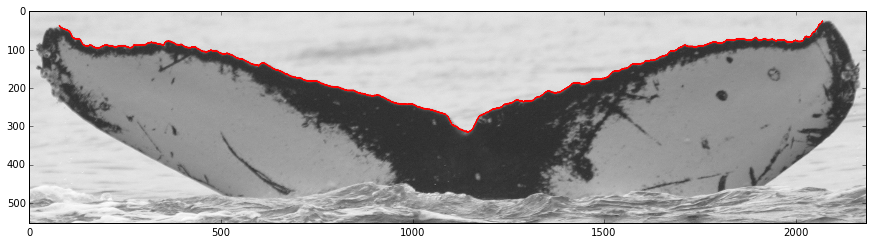

In [60]:
import random
def displayEdge(imginfo):
    img = cv2.imread(join(imgs_dir, imginfo['fn']))
    for edgePoint in imginfo['edge']:
        cv2.circle(img, edgePoint, 2, (255,0,0), thickness=-1)
    plt.figure(figsize=(15,15))
    plt.imshow(img)

displayEdge(random.choice(fb_curvatures))

In [87]:
curvatures_mult = filter(lambda x: len(id_img_map[x['id']]) > 1, fb_curvatures)

In [88]:
curvatures_good = list(filter(lambda x: 'edge' in x, curvatures_mult))
import cPickle as pickle
with open(join(dataset_loc, "Flukes/Flukebook/fb_edges.pkl"), 'w') as f:
    pickle.dump(curvatures_good, f)

In [90]:
max([len(i['edge']) for i in curvatures_good])

3746